## Exercise 2 HW: Introduction to Pytorch

As the first step, we need to install a suitable version of pytorch.
Go to https://pytorch.org/ and scroll down to the install section.
Pick the version fitting for your system and install it.
For example, if you do not have a GPU and you run Windows as your operating system:
```
conda activate idl23
conda install pytorch torchvision torchaudio cpuonly -c pytorch
```

You might need to separately install CUDA on your system if you want to use an NVIDIA GPU of your own computer.



Alternatively, you can use [Google Colab](https://colab.research.google.com/). 
This is a free service by Google that allows you to run Jupyter notebooks in their cloud. 
You can get GPU access by changing your runtime in top bar.
Their default environment has most standard packages installed, including pytorch.

## Polynomial Regression

Polynomial regression is slight more complex than linear regression.
Instead of just modeling the outcome as a linear combination of the features, polynomial regression models the output as a linear combination of polynomials of features.
In the case of a single feature, i.e., inputs $x \in \R$, the model is defined as:
$$f(x,w) = w_0 + w_1 x + w_2 x^2 + w_3 x^3 + \dots + w_q x^q.$$

In the more general case, where $x \in \R^p$, the model is defined as:
$$f(x,w) = w_0 + w_{11} x_1 + w_{12} x_1^2 + \dots + w_{1q} x_1^q + w_{21} x_2 + w_{22} x_2^2 + \dots + w_{2q} x_2^q + \dots = w_0 + \sum_{i=1}^p \sum_{j=1}^q w_{ij} x_i^j.$$

In this task, you implement a polynomial regression model in Pytorch and study the effects of the allowed complexity of the model on the quality of the fit to data.


1. Import pytorch and matplotlib.pyplot. The second library is commonly imported with the alias plt.

In [4]:
import torch
import matplotlib.pyplot as plt


This cell defines synthetic data that your model will have to fit. The ground truth labels will follow a polynomial of degree 3.

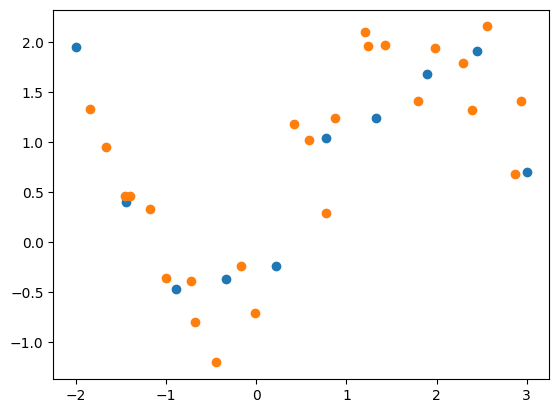

In [5]:
torch.manual_seed(123)
torch.use_deterministic_algorithms(True)
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = False

n_points = 10

def make_targets(x):
    return x + 0.5 * x**2 - 0.25 * x**3 + 0.4 * torch.randn_like(x)

x = torch.linspace(-2, 3, n_points).reshape(-1, 1)
y = make_targets(x)

x_val = torch.linspace(-2, 3, 25).reshape(-1, 1) + 0.1 * torch.randn((25, 1))
y_val = make_targets(x_val)

plt.scatter(x, y)
plt.scatter(x_val, y_val)

2. Implement a one-dimensional polynomial regression model.
    1. Create a class that inherits from `torch.nn.Module`
    2. Create the `__init__` method. What is necessary to call inside that method for classes that inherit from `Module`? The method should have an integer argument that specifies the degree of the polynomial that will be fitted. The weights can be created with an `nn.Linear` layer, but you can also look at different approaches like using `nn.parameter.Parameter`.
    3. Create the forward method. It should implement the first equation of this notebook: $$f(x,w) = w_0 + w_1 x + w_2 x^2 + w_3 x^3 + \dots + w_q x^q.$$


Hint 1: torch.pow can be used to take a value to some power.

Hint 2: Pytorch documentation can help you if you are stuck.


In [6]:
class PolyRegression(torch.nn.Module):
    def __init__(self, poly_degree: int):
        super().__init__()

        self.max_degree = poly_degree
        self.linear = torch.nn.Linear(self.max_degree, 1, bias=True)

    def forward(self, x):
        exponentiated_features = torch.concat(
            [torch.pow(x, exponent) for exponent in range(1, self.max_degree + 1)],
            dim=1,
        )
        return self.linear(exponentiated_features)


# Test that your models works
model = PolyRegression(3)
out = model(x)

3. Complete the following function that implements the training loop. It should implement the five general training steps.

In [7]:
def train_one_epoch(x, y, model, optimizer, loss_func):
    output = model(x)  # Step 1: forward pass
    loss = loss_func(output, y)  # Step 2: Compute loss
    optimizer.zero_grad()  # Step 3: Zero all .grad attributes
    loss.backward()  # Step 4: Compute gradients (populate .grad attributes)
    optimizer.step()  # Step 5: Update parameters based on gradients
    return loss.item()

4. Complete the following function that implements validation. Use the `torch.no_grad` function decorator or the `torch.no_grad` context manager inside this function to avoid making computations relevant for the gradient computation.

In [8]:
@torch.no_grad()
def eval(x, y, model, loss_func):
    output = model(x)
    loss = loss_func(output, y)
    return loss.item()

5. Combine the above functions to train a polynomial regression model with degree 3. The cell should instantiate a model, optimizer, and loss function, then iterate `n_epochs` many times over data to optimize the model. To ease optimization, use the `torch.optim.Adam` optimizer with `lr=5e-3`. To see whether you are overfitting, you can check the validation loss on `x_val, y_val` from time to time.

6. Name three hyperparameters you use in your code. *Solution*: Learning rate, degree of the polynomial, number of epochs.

In [9]:
torch.manual_seed(123)  # fixes initialization of parameters

model = PolyRegression(2)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
loss_func = torch.nn.MSELoss()

n_epochs = 5_000
print_every_n_epochs = 500
for epoch in range(n_epochs + 1):
    train_loss = train_one_epoch(x, y, model, optimizer, loss_func)

    if epoch % print_every_n_epochs == 0:
        val_loss = eval(x_val, y_val, model, loss_func)
        print(f"{epoch=}: train_loss={train_loss} val_loss={val_loss}")


epoch=0: train_loss=2.6442599296569824 val_loss=3.021416664123535
epoch=500: train_loss=0.5634238719940186 val_loss=0.7161001563072205
epoch=1000: train_loss=0.5629803538322449 val_loss=0.7103753089904785
epoch=1500: train_loss=0.5629803538322449 val_loss=0.7103606462478638
epoch=2000: train_loss=0.5629803538322449 val_loss=0.7103606462478638
epoch=2500: train_loss=0.5629802942276001 val_loss=0.710360586643219
epoch=3000: train_loss=0.5629802942276001 val_loss=0.710360586643219
epoch=3500: train_loss=0.5629802942276001 val_loss=0.710360586643219
epoch=4000: train_loss=0.5629802942276001 val_loss=0.710360586643219
epoch=4500: train_loss=0.5629802942276001 val_loss=0.710360586643219
epoch=5000: train_loss=0.5629802942276001 val_loss=0.7103604674339294


7. Visualize the resulting model with the following cell.

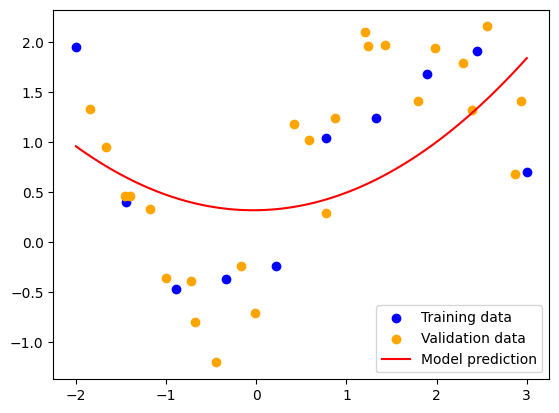

In [10]:
fig, ax = plt.subplots()
ax.scatter(x.view(-1), y.view(-1), color="blue", label="Training data")
ax.scatter(x_val.view(-1), y_val.view(-1), color="orange", label="Validation data")

with torch.no_grad():
    x_plot = torch.linspace(x.min().item(), x.max().item(), 100).view(-1, 1)
    pred_plot = model(x_plot)
    ax.plot(x_plot, pred_plot, label="Model prediction", color="red")

ax.legend()

8. Revisit the model training.
    1. Try to train a model with much higher degree of the polynomial. You may need to change the number of epochs and the learning rate of the optimizer. How does the fit compare to the fit of the model with order 3? *Solution*: If the optimization converges (which is not a given with the default hyperparameters---lower learning rate and higher number of epochs may be necessary), the model will fit the training data closely, but not necessarily other data that is drawn from the same distribution (In our case: different random noise). There is a high risk of overfitting.
    2. What happens if you train a model with degree 1 or 2? Are you over or underfitting; why? *Solution*: Because the true function of the data follows a higher order polynomial, the model will not be able to fit the data well. It is underfitting.

9. How would you classify this task in the scheme of slide 6 in deck 2? *Solution*: It is a supervised regression problem.